In [27]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
# To fetch financial data
import yfinance as yf

# For visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [3]:
# Set the ticker as 'EURUSD=X'
forex_data = yf.download('EURUSD=X', start='2019-01-02', end='2021-12-31')

# Set the index to a datetime object
forex_data.index = pd.to_datetime(forex_data.index)

# Display the last five rows
forex_data.tail()

# Set the ticker as 'EURUSD=X'
forex_data = yf.download('GBPUSD=X', period='120d', interval='1h')

# Set the index to a datetime object
forex_data.index = pd.to_datetime(forex_data.index)

# Display the last five rows
forex_data.tail()

forex_data.to_csv('a.csv')

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-24,1.132464,1.134430,1.130838,1.132734,1.132734,0
2021-12-27,1.132387,1.133500,1.130416,1.132426,1.132426,0
2021-12-28,1.132978,1.133600,1.129038,1.133003,1.133003,0
2021-12-29,1.131337,1.137001,1.127536,1.131478,1.131478,0
2021-12-30,1.135976,1.135976,1.130071,1.136015,1.136015,0


In [28]:
# load dataset
dataset = pd.read_csv('a.csv', header=0, usecols=['Open','High','Low','Close'])

#dataset.drop('dma', axis=1, inplace=True)

#print("column number")
#print(dataset.columns,len(dataset.columns),len(dataset.index))


dt = dataset.values
d = dt.astype(float)

print("Checkinf for NaN and Inf")
print( "np.nan=", np.where(np.isnan(d)))
print( "is.inf=", np.where(np.isinf(d)))

print("********************************************")
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(d)
d = imp.fit_transform(d)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(d)
print("scaled values",scaled)

# specify the number of lag hours
n_hours = 4
n_features = len(dataset.columns)
n_ahead = 4
n_obs = n_hours*n_features
dropnan=True

Checkinf for NaN and Inf
np.nan= (array([], dtype=int64), array([], dtype=int64))
is.inf= (array([], dtype=int64), array([], dtype=int64))
********************************************
scaled values [[0.96718009 0.96521573 0.97892358 0.96656051]
 [0.96767054 0.96958347 0.98231184 0.97167043]
 [0.97267926 0.97117362 0.98350863 0.96999894]
 ...
 [0.02960338 0.01992157 0.02916602 0.02896081]
 [0.02855164 0.01612518 0.02901304 0.02835956]
 [0.02967831 0.01612518 0.03015792 0.02835956]]


In [29]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

    

In [30]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_ahead)
print("column number")
print(reframed.columns,len(reframed.columns), len(reframed.index))

column number
Index(['var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var1(t-3)',
       'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var1(t-2)', 'var2(t-2)',
       'var3(t-2)', 'var4(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)',
       'var4(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var1(t+1)',
       'var2(t+1)', 'var3(t+1)', 'var4(t+1)', 'var1(t+2)', 'var2(t+2)',
       'var3(t+2)', 'var4(t+2)', 'var1(t+3)', 'var2(t+3)', 'var3(t+3)',
       'var4(t+3)'],
      dtype='object') 32 2834


In [32]:
# split into train and test sets
values = reframed.values
train_size = int(len(values) * 0.98)
test_size = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:len(dataset),:]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

(2777, 16) 2777 (2777,)


In [33]:
from numpy import concatenate
from matplotlib import pyplot
from tqdm import trange  
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.models import load_model

In [60]:
model = Sequential()

batchsize = 20
# design network
model.add(Bidirectional(LSTM(50,  activation='relu', input_shape=(n_hours, n_features), return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(20, activation='relu'))
model.add(Dense(n_ahead))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=batchsize, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 2777 samples, validate on 57 samples
Epoch 1/20
2777/2777 - 8s - loss: 0.2440 - val_loss: 0.0540
Epoch 2/20
2777/2777 - 2s - loss: 0.0656 - val_loss: 0.0473
Epoch 3/20
2777/2777 - 2s - loss: 0.0436 - val_loss: 0.0289
Epoch 4/20
2777/2777 - 2s - loss: 0.0397 - val_loss: 0.0231
Epoch 5/20
2777/2777 - 2s - loss: 0.0379 - val_loss: 0.0182
Epoch 6/20
2777/2777 - 2s - loss: 0.0354 - val_loss: 0.0156
Epoch 7/20
2777/2777 - 2s - loss: 0.0339 - val_loss: 0.0140
Epoch 8/20
2777/2777 - 2s - loss: 0.0299 - val_loss: 0.0133
Epoch 9/20
2777/2777 - 2s - loss: 0.0276 - val_loss: 0.0139
Epoch 10/20
2777/2777 - 2s - loss: 0.0294 - val_loss: 0.0144
Epoch 11/20
2777/2777 - 2s - loss: 0.0269 - val_loss: 0.0133
Epoch 12/20
2777/2777 - 2s - loss: 0.0271 - val_loss: 0.0132
Epoch 13/20
2777/2777 - 2s - loss: 0.0343 - val_loss: 0.0154
Epoch 14/20
2777/2777 - 2s - loss: 0.0304 - val_loss: 0.0136
Epoch 15/20
2777/2777 - 2s - loss: 0.0264 - val_loss: 0.0122
Epoch 16/20
2777/2777 - 2s - loss: 0.0270 - val_

In [61]:
# make a prediction
yhat = model.predict(test_X)
test_X.shape

yhat.shape

(57, 4)

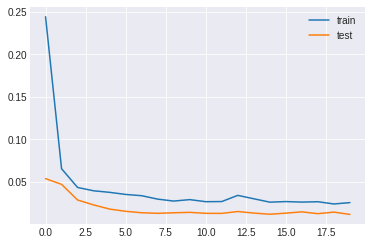

In [62]:

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [20]:
scores

0.02674523325522106

In [63]:
# evaluate the model
scores = model.evaluate(train_X, train_y, verbose=0)
print(model.metrics_names, scores*100)

['loss'] 6.663392570176955


In [64]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [65]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


Loaded model from disk


In [66]:
# make a prediction
yhat = loaded_model.predict(test_X)
test_X.shape

yhat.shape

(57, 4)

In [67]:
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [69]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -n_hours:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -n_hours:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.015


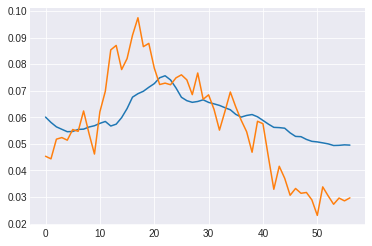

In [70]:
    pyplot.plot(inv_yhat)
    pyplot.plot(inv_y)
    pyplot.show()

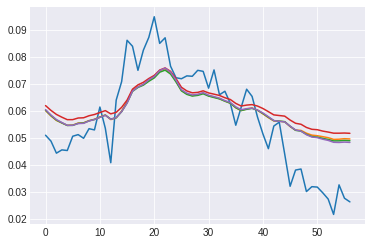

In [71]:
# pyplot.plot(train_X_plot[:,-4:-1])
# pyplot.plot(trainPredict)
# pyplot.show()

pyplot.plot(test_X[:,-1])
pyplot.plot(yhat)
#pyplot.show()

In [72]:
def make_forecast(model, look_back_buffer: np.ndarray, timesteps: int=1, batch_size: int=1):
    forecast_predict = np.empty((0, 1), dtype=np.float32)
    forecast_predict[:, :] = np.nan
    print("forecast_predict and lookBbuffer", forecast_predict.shape,look_back_buffer.shape)
    
    num_elements = look_back_buffer.shape[0]
    time_ahead = look_back_buffer.shape[1]
    feature = look_back_buffer.shape[2]
    
    flag = 1
    for _ in trange(timesteps, desc='predicting data\t', mininterval=1.0):
        # make prediction with current lookback buffer
        #cur_predict = model.predict(look_back_buffer, batch_size)
        cur_predict = model.predict(look_back_buffer, batch_size)
        print("Current predict", cur_predict.shape)
        
        if flag:
            flag = 0
            # add prediction to result
            forecast_predict = np.concatenate((forecast_predict, cur_predict))
            print("forecast predict flag 0:", forecast_predict.shape)
        else:
            # add prediction to result
            forecast_predict = np.concatenate((forecast_predict, cur_predict[-1:]), axis=0)
            print("forecast predict flag 1:", forecast_predict.shape)
            
        #‘C’ means to flaten in row-major (C-style) order.       
        look_back_buffer = look_back_buffer.flatten()
        look_back_buffer = np.delete(look_back_buffer, 0, axis=0)
        print("look_back_buffer",look_back_buffer.shape)
                        
        # cur_predict = cur_predict.flatten()
        look_back_buffer = np.concatenate((look_back_buffer,cur_predict[-1:]))
        look_back_buffer = look_back_buffer.reshape(num_elements,time_ahead,feature)        
        
    return forecast_predict

In [74]:
test_X.shape

(57, 16)

In [75]:
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

In [76]:
batchsize = 20
forecast_step = 50

In [77]:

forecast_predict = make_forecast(loaded_model, test_X, timesteps=forecast_step, batch_size=batchsize)
print("forecast_predict",forecast_predict.shape)

forecast_predict and lookBbuffer (0, 1) (57, 4, 4)


predicting data	:   0%|          | 0/50 [00:00<?, ?it/s]

Current predict (57, 4)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 4

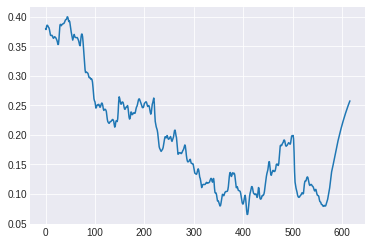

In [89]:
pyplot.plot(forecast_predict)

In [32]:
# invert predictions
testPredict = yhat
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

forecast_predict = scaler.inverse_transform(forecast_predict)

ValueError: non-broadcastable output operand with shape (2270,1) doesn't match the broadcast shape (2270,4)

In [ ]:


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='Data')
plt.plot(trainPredictPlot, label='trainprediction')
plt.plot(testPredictPlot, label='testprediction')
plot_data(look_back, trainPredict, testPredict, forecast_predict)
#plt.plot(forecast_predict)
plt.show()

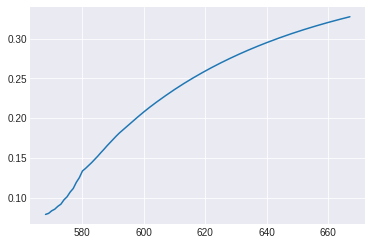

In [29]:
# shift test predictions for plotting
forecastPredictPlot = np.empty_like(yhat)
forecastPredictPlot[:, :] = np.nan
forecastplot = np.concatenate((forecastPredictPlot,forecast_predict))
pyplot.plot(forecastplot)
pyplot.show()


In [2]:
28%8

4